# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

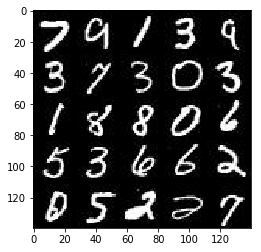

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

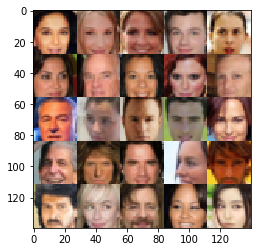

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_images = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='real_images')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    lr = tf.placeholder(tf.float32, [], name='learn_rate')

    return real_images, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    #Based on code from github.com/udacity/deep-learning/dcgan-svhn/DCGAN.ipynb
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28*28*image_channels
        cnv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * cnv1, cnv1)
        # 14x14x64
        
        cnv2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        # In the batch normalization for the discriminator,
        # training is always True because we only use the discriminator 
        # in training for this project and then discard it after training.
        bn2 = tf.layers.batch_normalization(cnv2, training=True) 
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        cnv3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(cnv3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256, or is it 3x3x256?

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256)) #might need to update this
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
7.0*7*256/(8*8)

196.0

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    #Based on code from github.com/udacity/deep-learning/dcgan-svhn/DCGAN.ipynb
    
    # Using alpha smaller in the generator than the discriminator, since it is closer to a normal ReLU, 
    # and Radford et al (2016) used a normal ReLU in their generator in their DCGAN paper.
    alpha = 0.1
    reuse = not is_train #If training, do not reuse.  If inference, then reuse.
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4*4*512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 196, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 8*8*196 now
        assert 8*8*196 == 7*7*256, 'Do not expect reshape to work as you expect!'
        x2 = tf.reshape(x2, (-1, 7, 7, 256))
        # 7*7*256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14*14*128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28*28*out_channel_dim now
        
        out = tf.tanh(logits)
        
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.01
    #Based on code from github.com/udacity/deep-learning/dcgan-svhn/DCGAN.ipynb
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=(1.0-smooth)*tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    #Based on code from github.com/udacity/deep-learning/dcgan-svhn/DCGAN.ipynb
    # Get all variables to train (weights and biases)
    t_vars = tf.trainable_variables()
    d_vars = [v for v in t_vars if v.name.startswith('discriminator')]
    g_vars = [v for v in t_vars if v.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    real_images, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_images, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    total_batches_so_far = 0
    n_imgs_to_show = 25
    print_every_n = 10 # number of batches to wait between printing status message
    show_every_n = 100 # number of batches to wait between showing examples
    losses = []
    samples = []
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                # Adapted some code below from github.com/udacity/deep-learning/dcgan-svhn/DCGAN.ipynb
                total_batches_so_far += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={real_images: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, real_images: batch_images, lr: learning_rate})

                if total_batches_so_far % print_every_n == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({real_images: batch_images, input_z: batch_z, lr: learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z, lr: learning_rate})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if total_batches_so_far % show_every_n == 0:
                    show_generator_output(sess, n_imgs_to_show, input_z, data_shape[3], data_image_mode)
                    #gen_samples = sess.run(
                    #               generator(z, 3, reuse=True, training=False),
                    #               feed_dict={input_z: batch_z})
                    #samples.append(gen_samples)
                    #_ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    #plt.show()

        saver.save(sess, './generator.ckpt')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [13]:
mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
print(mnist_dataset.shape)

(60000, 28, 28, 1)


Epoch 1/2... Discriminator Loss: 0.9117... Generator Loss: 0.6327
Epoch 1/2... Discriminator Loss: 0.5157... Generator Loss: 1.2449
Epoch 1/2... Discriminator Loss: 0.4483... Generator Loss: 2.9457
Epoch 1/2... Discriminator Loss: 4.6530... Generator Loss: 0.0111
Epoch 1/2... Discriminator Loss: 0.4268... Generator Loss: 1.5790
Epoch 1/2... Discriminator Loss: 0.7283... Generator Loss: 7.6510
Epoch 1/2... Discriminator Loss: 0.3894... Generator Loss: 1.6415
Epoch 1/2... Discriminator Loss: 0.2723... Generator Loss: 2.5835
Epoch 1/2... Discriminator Loss: 0.2941... Generator Loss: 2.0136
Epoch 1/2... Discriminator Loss: 0.2832... Generator Loss: 2.0401


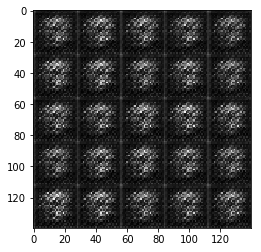

Epoch 1/2... Discriminator Loss: 1.5639... Generator Loss: 0.2770
Epoch 1/2... Discriminator Loss: 0.5161... Generator Loss: 7.1699
Epoch 1/2... Discriminator Loss: 0.2961... Generator Loss: 2.1595
Epoch 1/2... Discriminator Loss: 0.3326... Generator Loss: 2.1803
Epoch 1/2... Discriminator Loss: 0.2407... Generator Loss: 4.3523
Epoch 1/2... Discriminator Loss: 0.2193... Generator Loss: 2.1104
Epoch 1/2... Discriminator Loss: 0.2655... Generator Loss: 2.1887
Epoch 1/2... Discriminator Loss: 0.2867... Generator Loss: 2.2597
Epoch 1/2... Discriminator Loss: 0.1888... Generator Loss: 2.7680
Epoch 1/2... Discriminator Loss: 0.1965... Generator Loss: 3.1731


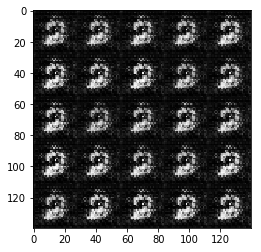

Epoch 1/2... Discriminator Loss: 0.1852... Generator Loss: 2.6821
Epoch 1/2... Discriminator Loss: 0.1338... Generator Loss: 3.1822
Epoch 1/2... Discriminator Loss: 0.1346... Generator Loss: 3.2861
Epoch 1/2... Discriminator Loss: 0.1443... Generator Loss: 3.3316
Epoch 1/2... Discriminator Loss: 0.1403... Generator Loss: 3.7050
Epoch 1/2... Discriminator Loss: 0.2022... Generator Loss: 2.5626
Epoch 1/2... Discriminator Loss: 0.1747... Generator Loss: 2.9548
Epoch 1/2... Discriminator Loss: 0.2284... Generator Loss: 2.3778
Epoch 1/2... Discriminator Loss: 0.1474... Generator Loss: 3.8985
Epoch 1/2... Discriminator Loss: 0.1169... Generator Loss: 4.3318


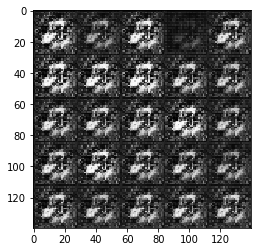

Epoch 1/2... Discriminator Loss: 0.1833... Generator Loss: 2.3632
Epoch 1/2... Discriminator Loss: 0.1465... Generator Loss: 5.6058
Epoch 1/2... Discriminator Loss: 0.2364... Generator Loss: 3.8707
Epoch 1/2... Discriminator Loss: 1.2137... Generator Loss: 0.6785
Epoch 1/2... Discriminator Loss: 0.3406... Generator Loss: 1.8846
Epoch 1/2... Discriminator Loss: 0.3719... Generator Loss: 1.5865
Epoch 1/2... Discriminator Loss: 0.2372... Generator Loss: 2.3555
Epoch 1/2... Discriminator Loss: 0.3166... Generator Loss: 4.3607
Epoch 1/2... Discriminator Loss: 0.4397... Generator Loss: 6.9904
Epoch 1/2... Discriminator Loss: 0.2435... Generator Loss: 3.7400


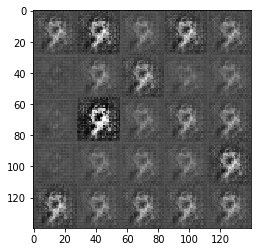

Epoch 1/2... Discriminator Loss: 0.5514... Generator Loss: 6.4240
Epoch 1/2... Discriminator Loss: 0.2401... Generator Loss: 2.8954
Epoch 1/2... Discriminator Loss: 0.2344... Generator Loss: 2.9214
Epoch 1/2... Discriminator Loss: 0.2195... Generator Loss: 2.7786
Epoch 1/2... Discriminator Loss: 0.2907... Generator Loss: 2.2923
Epoch 1/2... Discriminator Loss: 0.2703... Generator Loss: 2.8997
Epoch 2/2... Discriminator Loss: 0.2525... Generator Loss: 2.1685
Epoch 2/2... Discriminator Loss: 0.2881... Generator Loss: 2.3377
Epoch 2/2... Discriminator Loss: 0.2873... Generator Loss: 2.1021
Epoch 2/2... Discriminator Loss: 0.2586... Generator Loss: 2.5199


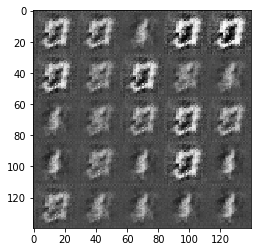

Epoch 2/2... Discriminator Loss: 0.2169... Generator Loss: 3.3946
Epoch 2/2... Discriminator Loss: 0.2433... Generator Loss: 2.6342
Epoch 2/2... Discriminator Loss: 0.2762... Generator Loss: 2.0206
Epoch 2/2... Discriminator Loss: 0.2004... Generator Loss: 2.8837
Epoch 2/2... Discriminator Loss: 0.1371... Generator Loss: 3.1409
Epoch 2/2... Discriminator Loss: 0.2270... Generator Loss: 2.6470
Epoch 2/2... Discriminator Loss: 0.1603... Generator Loss: 3.7952
Epoch 2/2... Discriminator Loss: 0.1724... Generator Loss: 3.0888
Epoch 2/2... Discriminator Loss: 0.2158... Generator Loss: 6.2751
Epoch 2/2... Discriminator Loss: 0.6417... Generator Loss: 12.8624


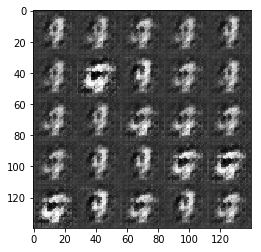

Epoch 2/2... Discriminator Loss: 0.1810... Generator Loss: 3.4170
Epoch 2/2... Discriminator Loss: 0.1771... Generator Loss: 3.1232
Epoch 2/2... Discriminator Loss: 0.2099... Generator Loss: 2.7489
Epoch 2/2... Discriminator Loss: 0.3143... Generator Loss: 5.4789
Epoch 2/2... Discriminator Loss: 0.1409... Generator Loss: 3.3046
Epoch 2/2... Discriminator Loss: 0.1760... Generator Loss: 2.8870
Epoch 2/2... Discriminator Loss: 0.1829... Generator Loss: 2.7517
Epoch 2/2... Discriminator Loss: 0.1914... Generator Loss: 2.6927
Epoch 2/2... Discriminator Loss: 0.2127... Generator Loss: 3.7841
Epoch 2/2... Discriminator Loss: 0.1839... Generator Loss: 3.7219


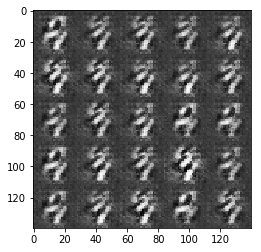

Epoch 2/2... Discriminator Loss: 0.1909... Generator Loss: 2.5326
Epoch 2/2... Discriminator Loss: 0.3560... Generator Loss: 9.2788
Epoch 2/2... Discriminator Loss: 0.2043... Generator Loss: 4.0494
Epoch 2/2... Discriminator Loss: 0.1526... Generator Loss: 3.2718
Epoch 2/2... Discriminator Loss: 0.1757... Generator Loss: 3.0905
Epoch 2/2... Discriminator Loss: 0.1565... Generator Loss: 3.3287
Epoch 2/2... Discriminator Loss: 0.1541... Generator Loss: 3.3712
Epoch 2/2... Discriminator Loss: 0.1953... Generator Loss: 5.3154
Epoch 2/2... Discriminator Loss: 0.2638... Generator Loss: 5.0946
Epoch 2/2... Discriminator Loss: 0.2420... Generator Loss: 2.3479


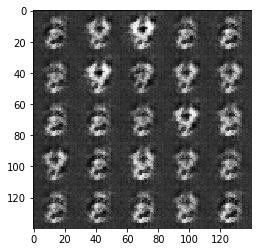

Epoch 2/2... Discriminator Loss: 0.2036... Generator Loss: 4.8715
Epoch 2/2... Discriminator Loss: 0.2718... Generator Loss: 12.1691
Epoch 2/2... Discriminator Loss: 0.2905... Generator Loss: 3.1468
Epoch 2/2... Discriminator Loss: 0.2179... Generator Loss: 4.1058
Epoch 2/2... Discriminator Loss: 0.1967... Generator Loss: 3.2532
Epoch 2/2... Discriminator Loss: 0.1995... Generator Loss: 2.7714
Epoch 2/2... Discriminator Loss: 0.1412... Generator Loss: 3.2815
Epoch 2/2... Discriminator Loss: 0.1629... Generator Loss: 3.1231
Epoch 2/2... Discriminator Loss: 0.1649... Generator Loss: 4.6320
Epoch 2/2... Discriminator Loss: 0.1457... Generator Loss: 3.5825


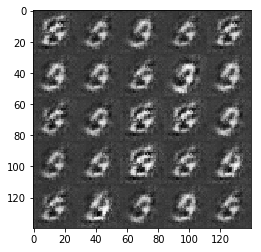

Epoch 2/2... Discriminator Loss: 0.2250... Generator Loss: 2.5763
Epoch 2/2... Discriminator Loss: 0.2273... Generator Loss: 2.3911
Epoch 2/2... Discriminator Loss: 0.2376... Generator Loss: 5.7201


In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.6511... Generator Loss: 0.5069
Epoch 1/1... Discriminator Loss: 0.7674... Generator Loss: 1.0346
Epoch 1/1... Discriminator Loss: 0.3761... Generator Loss: 1.9769
Epoch 1/1... Discriminator Loss: 0.3699... Generator Loss: 1.7436
Epoch 1/1... Discriminator Loss: 0.3954... Generator Loss: 1.6305
Epoch 1/1... Discriminator Loss: 1.4741... Generator Loss: 10.2346
Epoch 1/1... Discriminator Loss: 0.4236... Generator Loss: 1.5301
Epoch 1/1... Discriminator Loss: 0.3417... Generator Loss: 2.0807
Epoch 1/1... Discriminator Loss: 0.3601... Generator Loss: 4.8694
Epoch 1/1... Discriminator Loss: 0.1756... Generator Loss: 3.9002


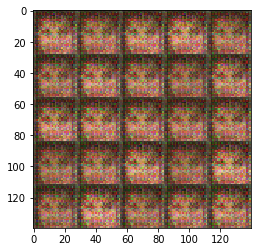

Epoch 1/1... Discriminator Loss: 0.5749... Generator Loss: 1.3361
Epoch 1/1... Discriminator Loss: 0.4506... Generator Loss: 1.6718
Epoch 1/1... Discriminator Loss: 0.7572... Generator Loss: 0.9735
Epoch 1/1... Discriminator Loss: 0.4107... Generator Loss: 3.1553
Epoch 1/1... Discriminator Loss: 0.2215... Generator Loss: 2.8807
Epoch 1/1... Discriminator Loss: 0.1499... Generator Loss: 2.8710
Epoch 1/1... Discriminator Loss: 0.3247... Generator Loss: 1.9055
Epoch 1/1... Discriminator Loss: 0.9639... Generator Loss: 0.6160
Epoch 1/1... Discriminator Loss: 0.3221... Generator Loss: 2.5688
Epoch 1/1... Discriminator Loss: 1.6266... Generator Loss: 0.3415


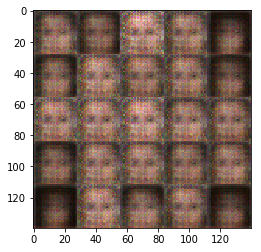

Epoch 1/1... Discriminator Loss: 1.5283... Generator Loss: 3.8972
Epoch 1/1... Discriminator Loss: 1.1451... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 0.4337... Generator Loss: 5.3053
Epoch 1/1... Discriminator Loss: 0.9900... Generator Loss: 2.2377
Epoch 1/1... Discriminator Loss: 1.3447... Generator Loss: 0.7823
Epoch 1/1... Discriminator Loss: 1.0813... Generator Loss: 0.8212
Epoch 1/1... Discriminator Loss: 1.1123... Generator Loss: 1.0539
Epoch 1/1... Discriminator Loss: 0.7729... Generator Loss: 1.8266
Epoch 1/1... Discriminator Loss: 1.0105... Generator Loss: 1.0845
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.8484


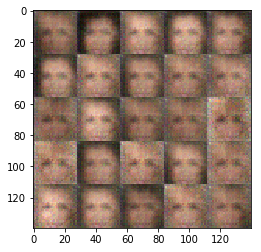

Epoch 1/1... Discriminator Loss: 1.0666... Generator Loss: 1.1455
Epoch 1/1... Discriminator Loss: 0.9567... Generator Loss: 1.1076
Epoch 1/1... Discriminator Loss: 0.7316... Generator Loss: 1.3732
Epoch 1/1... Discriminator Loss: 0.9853... Generator Loss: 1.1063
Epoch 1/1... Discriminator Loss: 0.6846... Generator Loss: 1.5692
Epoch 1/1... Discriminator Loss: 0.7569... Generator Loss: 1.7325
Epoch 1/1... Discriminator Loss: 0.9667... Generator Loss: 1.3734
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.4868
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 1.8663
Epoch 1/1... Discriminator Loss: 0.6982... Generator Loss: 1.6115


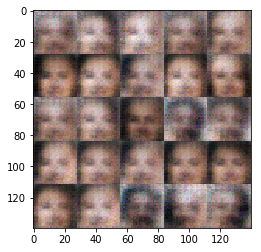

Epoch 1/1... Discriminator Loss: 0.9623... Generator Loss: 0.7201
Epoch 1/1... Discriminator Loss: 1.6353... Generator Loss: 0.5039
Epoch 1/1... Discriminator Loss: 0.9069... Generator Loss: 1.2528
Epoch 1/1... Discriminator Loss: 1.0045... Generator Loss: 1.2451
Epoch 1/1... Discriminator Loss: 0.7650... Generator Loss: 1.5063
Epoch 1/1... Discriminator Loss: 0.7743... Generator Loss: 0.9945
Epoch 1/1... Discriminator Loss: 0.6337... Generator Loss: 1.2327
Epoch 1/1... Discriminator Loss: 0.5110... Generator Loss: 1.3169
Epoch 1/1... Discriminator Loss: 0.6115... Generator Loss: 1.7963
Epoch 1/1... Discriminator Loss: 1.0123... Generator Loss: 0.6242


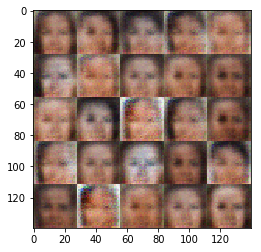

Epoch 1/1... Discriminator Loss: 0.3867... Generator Loss: 2.8879
Epoch 1/1... Discriminator Loss: 0.3627... Generator Loss: 1.8164
Epoch 1/1... Discriminator Loss: 1.8412... Generator Loss: 5.9625
Epoch 1/1... Discriminator Loss: 1.9898... Generator Loss: 0.2467
Epoch 1/1... Discriminator Loss: 0.7625... Generator Loss: 0.8811
Epoch 1/1... Discriminator Loss: 0.3384... Generator Loss: 3.5046
Epoch 1/1... Discriminator Loss: 0.4948... Generator Loss: 3.4906
Epoch 1/1... Discriminator Loss: 0.2196... Generator Loss: 2.7485
Epoch 1/1... Discriminator Loss: 0.5320... Generator Loss: 1.8170
Epoch 1/1... Discriminator Loss: 0.2095... Generator Loss: 4.2302


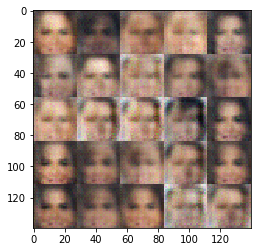

Epoch 1/1... Discriminator Loss: 0.7326... Generator Loss: 3.4078
Epoch 1/1... Discriminator Loss: 2.0640... Generator Loss: 0.1868
Epoch 1/1... Discriminator Loss: 0.1781... Generator Loss: 5.0817
Epoch 1/1... Discriminator Loss: 0.5806... Generator Loss: 2.9129
Epoch 1/1... Discriminator Loss: 0.7578... Generator Loss: 0.9415
Epoch 1/1... Discriminator Loss: 0.7459... Generator Loss: 0.9224
Epoch 1/1... Discriminator Loss: 0.4858... Generator Loss: 4.3752
Epoch 1/1... Discriminator Loss: 0.5863... Generator Loss: 5.2422
Epoch 1/1... Discriminator Loss: 0.1917... Generator Loss: 4.5387
Epoch 1/1... Discriminator Loss: 1.0715... Generator Loss: 0.7009


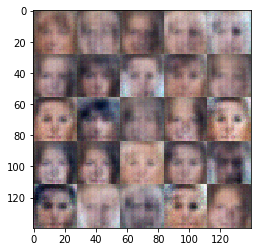

Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.3918
Epoch 1/1... Discriminator Loss: 0.2678... Generator Loss: 4.8341
Epoch 1/1... Discriminator Loss: 0.7171... Generator Loss: 2.7202
Epoch 1/1... Discriminator Loss: 0.9302... Generator Loss: 0.7514
Epoch 1/1... Discriminator Loss: 0.4124... Generator Loss: 1.5228
Epoch 1/1... Discriminator Loss: 1.2572... Generator Loss: 0.4982
Epoch 1/1... Discriminator Loss: 0.9019... Generator Loss: 0.9086
Epoch 1/1... Discriminator Loss: 0.3646... Generator Loss: 1.9956
Epoch 1/1... Discriminator Loss: 1.5191... Generator Loss: 3.7835
Epoch 1/1... Discriminator Loss: 1.5407... Generator Loss: 4.6552


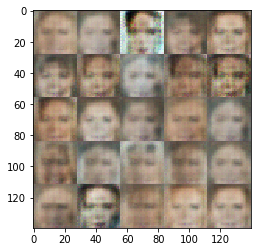

Epoch 1/1... Discriminator Loss: 0.4825... Generator Loss: 1.7788
Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 2.1549
Epoch 1/1... Discriminator Loss: 2.1267... Generator Loss: 0.1898
Epoch 1/1... Discriminator Loss: 0.6141... Generator Loss: 1.8371
Epoch 1/1... Discriminator Loss: 0.9090... Generator Loss: 3.4789
Epoch 1/1... Discriminator Loss: 0.9470... Generator Loss: 0.8553
Epoch 1/1... Discriminator Loss: 0.5367... Generator Loss: 1.5048
Epoch 1/1... Discriminator Loss: 0.2513... Generator Loss: 2.8837
Epoch 1/1... Discriminator Loss: 1.2021... Generator Loss: 4.9491
Epoch 1/1... Discriminator Loss: 0.5015... Generator Loss: 2.9134


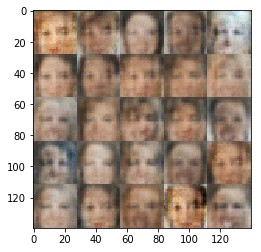

Epoch 1/1... Discriminator Loss: 0.3411... Generator Loss: 2.7823
Epoch 1/1... Discriminator Loss: 1.6526... Generator Loss: 0.3063
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.5071
Epoch 1/1... Discriminator Loss: 2.9732... Generator Loss: 0.0841
Epoch 1/1... Discriminator Loss: 0.6091... Generator Loss: 2.4059
Epoch 1/1... Discriminator Loss: 0.7911... Generator Loss: 1.6594
Epoch 1/1... Discriminator Loss: 0.4227... Generator Loss: 3.5960
Epoch 1/1... Discriminator Loss: 0.2811... Generator Loss: 4.1491
Epoch 1/1... Discriminator Loss: 3.3282... Generator Loss: 0.0532
Epoch 1/1... Discriminator Loss: 0.6227... Generator Loss: 1.1046


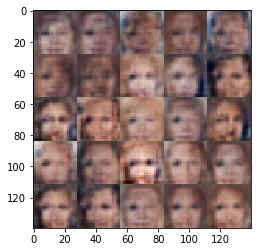

Epoch 1/1... Discriminator Loss: 0.8432... Generator Loss: 0.8995
Epoch 1/1... Discriminator Loss: 0.1596... Generator Loss: 3.1980
Epoch 1/1... Discriminator Loss: 0.5451... Generator Loss: 6.4004
Epoch 1/1... Discriminator Loss: 0.4998... Generator Loss: 1.2640
Epoch 1/1... Discriminator Loss: 0.5810... Generator Loss: 1.2423
Epoch 1/1... Discriminator Loss: 1.7912... Generator Loss: 1.6824
Epoch 1/1... Discriminator Loss: 0.9135... Generator Loss: 2.4737
Epoch 1/1... Discriminator Loss: 0.5047... Generator Loss: 1.8567
Epoch 1/1... Discriminator Loss: 1.9468... Generator Loss: 0.1970
Epoch 1/1... Discriminator Loss: 0.3994... Generator Loss: 1.6052


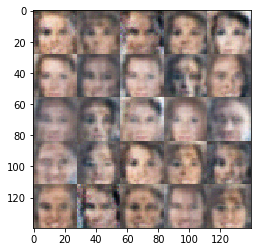

Epoch 1/1... Discriminator Loss: 0.8762... Generator Loss: 3.3897
Epoch 1/1... Discriminator Loss: 2.1731... Generator Loss: 0.1613
Epoch 1/1... Discriminator Loss: 0.6496... Generator Loss: 2.2562
Epoch 1/1... Discriminator Loss: 0.7183... Generator Loss: 3.2097
Epoch 1/1... Discriminator Loss: 0.4792... Generator Loss: 3.5249
Epoch 1/1... Discriminator Loss: 0.5809... Generator Loss: 4.8109
Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 2.8267
Epoch 1/1... Discriminator Loss: 1.0775... Generator Loss: 3.8817
Epoch 1/1... Discriminator Loss: 0.3652... Generator Loss: 1.6211
Epoch 1/1... Discriminator Loss: 1.7308... Generator Loss: 0.2512


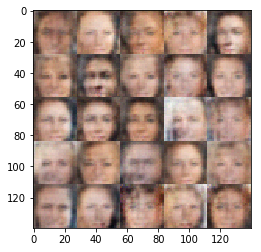

Epoch 1/1... Discriminator Loss: 1.0617... Generator Loss: 4.1321
Epoch 1/1... Discriminator Loss: 0.3527... Generator Loss: 2.1546
Epoch 1/1... Discriminator Loss: 0.6703... Generator Loss: 0.9518
Epoch 1/1... Discriminator Loss: 0.3082... Generator Loss: 3.7609
Epoch 1/1... Discriminator Loss: 0.1068... Generator Loss: 4.4034
Epoch 1/1... Discriminator Loss: 0.3221... Generator Loss: 2.5743
Epoch 1/1... Discriminator Loss: 0.5043... Generator Loss: 1.3422
Epoch 1/1... Discriminator Loss: 0.3173... Generator Loss: 1.9990
Epoch 1/1... Discriminator Loss: 0.1396... Generator Loss: 4.2357
Epoch 1/1... Discriminator Loss: 0.1231... Generator Loss: 5.9370


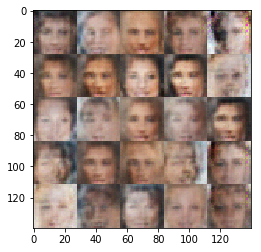

Epoch 1/1... Discriminator Loss: 0.1410... Generator Loss: 3.4950
Epoch 1/1... Discriminator Loss: 0.1276... Generator Loss: 5.9868
Epoch 1/1... Discriminator Loss: 0.1370... Generator Loss: 3.6223
Epoch 1/1... Discriminator Loss: 0.2461... Generator Loss: 4.9853
Epoch 1/1... Discriminator Loss: 0.1208... Generator Loss: 3.0755
Epoch 1/1... Discriminator Loss: 0.1357... Generator Loss: 5.4222
Epoch 1/1... Discriminator Loss: 0.4499... Generator Loss: 8.2581
Epoch 1/1... Discriminator Loss: 0.1161... Generator Loss: 5.7596
Epoch 1/1... Discriminator Loss: 0.2162... Generator Loss: 10.4380
Epoch 1/1... Discriminator Loss: 0.0954... Generator Loss: 6.2451


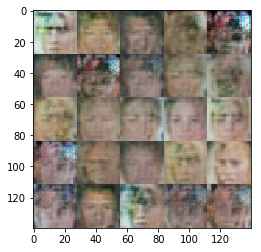

Epoch 1/1... Discriminator Loss: 0.0757... Generator Loss: 5.6937
Epoch 1/1... Discriminator Loss: 0.0703... Generator Loss: 6.3502
Epoch 1/1... Discriminator Loss: 0.1662... Generator Loss: 7.4116
Epoch 1/1... Discriminator Loss: 0.1317... Generator Loss: 3.0244
Epoch 1/1... Discriminator Loss: 0.5101... Generator Loss: 1.2257
Epoch 1/1... Discriminator Loss: 0.0816... Generator Loss: 5.6639
Epoch 1/1... Discriminator Loss: 0.2327... Generator Loss: 6.9833
Epoch 1/1... Discriminator Loss: 0.3662... Generator Loss: 1.5981
Epoch 1/1... Discriminator Loss: 0.1007... Generator Loss: 3.8220
Epoch 1/1... Discriminator Loss: 0.2817... Generator Loss: 1.9892


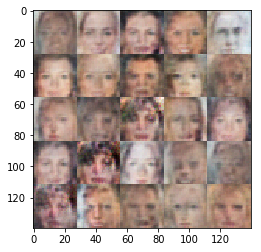

Epoch 1/1... Discriminator Loss: 0.0914... Generator Loss: 4.6767
Epoch 1/1... Discriminator Loss: 0.4249... Generator Loss: 1.3237
Epoch 1/1... Discriminator Loss: 0.0656... Generator Loss: 8.1940
Epoch 1/1... Discriminator Loss: 0.0959... Generator Loss: 8.6461
Epoch 1/1... Discriminator Loss: 0.0805... Generator Loss: 4.6013
Epoch 1/1... Discriminator Loss: 0.0788... Generator Loss: 5.3817
Epoch 1/1... Discriminator Loss: 0.0640... Generator Loss: 7.2729
Epoch 1/1... Discriminator Loss: 0.0944... Generator Loss: 3.9956


In [15]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.